<a href="https://colab.research.google.com/github/bhishanpdl/Project_House_Price_Prediction/blob/master/notebooks/c03_regression_modelling_sklearn_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Scaling-and-making-pipeline" data-toc-modified-id="Scaling-and-making-pipeline-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scaling and making pipeline</a></span></li><li><span><a href="#Log-transform-large-values" data-toc-modified-id="Log-transform-large-values-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Log transform large values</a></span></li></ul></div>

# Data Description

This dataset contains house sale prices for King County,
which includes Seattle.
It includes homes sold between May 2014 and May 2015.

- Dependent features: 1 (price)
- Features : 19 home features
- Id:  1 house ID

Task: Try to estimate the price based on given features.

![](https://github.com/bhishanpdl/Project_House_Price_Prediction/blob/master/data/raw/data_description.png?raw=1)

# Imports

In [0]:
import sys
IN_BHISHAN = 'bhishan' in sys.modules

if IN_BHISHAN:
    import src
    import bhishan
    %load_ext autoreload
    %autoreload 2

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install hpsklearn

    # set OMP_NUM_THREADS=1 for hpsklearn package
    !export OMP_NUM_THREADS=1

     |████████████████████████████████| 163kB 7.7MB/s 
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-cp36-none-any.whl size=23913 sha256=76527173918f624b67263eefd48832783a6d8f12c1682b770b55efaed5a1ea14
  Stored in directory: /root/.cache/pip/wheels/41/ee/c4/3c267cbf78f0905434ee36b915d97a20610ad3af7ff3c75852
Successfully built hpsklearn


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time

# random state
random_state=100
np.random.seed(random_state) # we need this in each cell
np.random.set_state=random_state

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', 200)
# pd.set_option('display.float_format', '{:,.4f}'.format) # numbers sep by comma
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 200)

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.17.4'), ('pandas', '0.25.3'), ('seaborn', '0.9.0'), ('matplotlib', '3.1.1')]


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [5]:
import scipy
import sklearn

print([(x.__name__,x.__version__) for x in [scipy, sklearn]])

[('scipy', '1.3.2'), ('sklearn', '0.21.3')]


In [0]:
# scale and split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
# regressors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
# regressor preprocessing
from sklearn.preprocessing import PolynomialFeatures

In [0]:
# pipeline
from sklearn.pipeline import Pipeline

In [0]:
# metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [0]:
# cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [0]:
df_eval = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

# Important Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [0]:
def adjustedR2(rsquared,nrows,kcols):
    return rsquared- (kcols-1)/(nrows-kcols) * (1-rsquared)

# Load the data

In [15]:
# df_clean = pd.read_csv('../data/processed/data_cleaned_encoded.csv')
df_clean = pd.read_csv('https://github.com/bhishanpdl/Project_House_Price_Prediction/blob/master/data/processed/data_cleaned_encoded.csv?raw=true')
print(df_clean.shape)
df_clean.head()

(21613, 92)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sales,age,yr_renovated2,age_after_renovation,zipcode_top10,zipcode_houses,basement_bool,renovation_bool,age_cat,age_after_renovation_cat,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,grade_1,grade_10,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,zipcode_top10_98004,zipcode_top10_98006,zipcode_top10_98033,zipcode_top10_98039,zipcode_top10_98040,zipcode_top10_98102,zipcode_top10_98105,zipcode_top10_98155,zipcode_top10_98177,zipcode_top10_others,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4,age_cat_5,age_cat_6,age_cat_7,age_cat_8,age_cat_9,age_after_renovation_cat_0,age_after_renovation_cat_1,age_after_renovation_cat_2,age_after_renovation_cat_3,age_after_renovation_cat_4,age_after_renovation_cat_5,age_after_renovation_cat_6,age_after_renovation_cat_7,age_after_renovation_cat_8,age_after_renovation_cat_9,log1p_price,log1p_sqft_living,log1p_sqft_lot,log1p_sqft_above,log1p_sqft_basement,log1p_sqft_living15,log1p_sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,59,1955,59,others,262,0,0,5,5,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12.309987,7.074117,8.639588,7.074117,0.000000,7.201171,8.639588
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,63,1991,23,others,410,1,1,5,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,13.195616,7.852050,8.887791,7.682943,5.993961,7.433075,8.941153
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,82,1933,82,others,283,0,0,7,7,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,12.100718,6.647688,9.210440,6.647688,0.000000,7.908755,8.995041
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,49,1965,49,others,263,1,0,4,4,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,13.311331,7.581210,8.517393,6.957497,6.814543,7.215975,8.517393
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,28,1987,28,others,441,0,0,2,2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,13.142168,7.427144,8.997271,7.427144,0.000000,7.496097,8.923191


In [16]:
# I will just take column names from this and will use cleaned data further.
# df_raw = pd.read_csv('../data/raw/kc_house_data.csv')
df_raw = pd.read_csv('https://github.com/bhishanpdl/Project_House_Price_Prediction/blob/master/data/raw/kc_house_data.csv?raw=true',nrows=1)
df_raw.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [0]:
features_raw_all = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']

df = df_clean[features_raw_all + ['price']]

# Log transform large values

In [18]:
log_cols = ['price','sqft_living','sqft_living15','sqft_lot','sqft_lot15']

for col in log_cols:
    df[col] = np.log1p(df[col].to_numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Train-Test split after log transform

In [19]:
X = df[features_raw_all].to_numpy()

y = df['price'].to_numpy()

Xtrain, Xtest, ytrain, ytest = train_test_split (X,y,
                                                     test_size=0.20,
                                                     random_state=random_state)

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((17290, 18), (17290,), (4323, 18), (4323,))

# Making pipeline for various sklearn Regressors (with automatic scaling)

In [0]:
pipelines = []

pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),
                                        ('LR',LinearRegression())])) )


pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),
                                           ('LASSO', Lasso())])))

pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),
                                        ('EN', ElasticNet())])))

pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),
                                         ('KNN', KNeighborsRegressor())])))

# decision tree may not need scaling
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler())
                                          ,('DT', DecisionTreeRegressor())])))

# boosting may not need scaling
pipelines.append(('ScaledGBR', Pipeline([('Scaler', StandardScaler()),
                                         ('GBR', GradientBoostingRegressor())])))

In [0]:
df_cv = pd.DataFrame({'Model': [],
                      '10-Fold Cross Validation Mean':[],
                      '10-Fold Cross Validation Std':[]
                     })


In [0]:
# pipeline will scale the data and then fit the data
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=random_state)
    cv_results = cross_val_score(model,
                                 Xtrain,
                                 ytrain,
                                 cv=kfold,
                                 scoring='neg_mean_squared_error'
                                 )

    df_cv.loc[len(df_cv)] = [name, cv_results.mean(), cv_results.std() ]

In [23]:
df_cv.sort_values('10-Fold Cross Validation Mean',ascending=False) # smallest rmse is best, largest negMSE is best.

# observation:
# we have values of power 10, its bad, we need more iteration or need to log transform features.

,Model,10-Fold Cross Validation Mean,10-Fold Cross Validation Std
5,ScaledGBR,-0.034164,0.001455
3,ScaledKNN,-0.046319,0.002454
0,ScaledLR,-0.062666,0.002355
4,ScaledDT,-0.064170,0.002628
1,ScaledLASSO,-0.276666,0.010241
2,ScaledEN,-0.276666,0.010241


# Hyperparameter Tuning

## Grid Search for Gradient Boosting Regressor

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html 


Grid search is extremely slow. It need to fit the model for all the values in the
search space.

In [24]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# we use gradient boosting regressor, since it gave us the best model.



param_grid = dict(n_estimators=np.array([50,100,200,300,400,500,600,700,800]))

model = GradientBoostingRegressor(random_state=random_state)
kfold = KFold(n_splits=10, random_state=random_state)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=kfold)

grid_result = grid.fit(Xtrain, ytrain)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_grid_gbr = pd.DataFrame({'n_estimators': params,
                           'neg_mean_squared_error': means,
                           'std': stds})

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pd.set_option('display.float_format', '{:,.10f}'.format)
df_grid_gbr.sort_values('neg_mean_squared_error', ascending=False)

Best: -0.027883 using {'n_estimators': 800}
CPU times: user 7min 45s, sys: 51.3 ms, total: 7min 46s
Wall time: 7min 46s


In [25]:
%%time

# best n_estimators found was the largest value.
# We need to look more than the maximum value.


param_grid = dict(n_estimators=np.array([850,900,950,1000]))

model = GradientBoostingRegressor(random_state=random_state)
kfold = KFold(n_splits=10, random_state=random_state)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=kfold)

grid_result = grid.fit(Xtrain, ytrain)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_grid_gbr = pd.DataFrame({'n_estimators': params,
                           'neg_mean_squared_error': means,
                           'std': stds})

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pd.set_option('display.float_format', '{:,.10f}'.format)
df_grid_gbr.sort_values('neg_mean_squared_error', ascending=False)

Best: -0.027759 using {'n_estimators': 1000}
CPU times: user 7min 52s, sys: 38.9 ms, total: 7min 52s
Wall time: 7min 52s


In [26]:
n_estimators_best = grid_result.best_params_['n_estimators']
n_estimators_best

1000

In [27]:
%%time

# best n_estimators found was the largest value.
# We need to look more than the maximum value.


param_grid = dict(n_estimators=np.array([1050,1100,1200,1300]))

model = GradientBoostingRegressor(random_state=random_state)
kfold = KFold(n_splits=10, random_state=random_state)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=kfold)

grid_result = grid.fit(Xtrain, ytrain)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
df_grid_gbr = pd.DataFrame({'n_estimators': params,
                           'neg_mean_squared_error': means,
                           'std': stds})

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
pd.set_option('display.float_format', '{:,.10f}'.format)
df_grid_gbr.sort_values('neg_mean_squared_error', ascending=False)

Best: -0.027719 using {'n_estimators': 1200}
CPU times: user 10min 5s, sys: 64.9 ms, total: 10min 5s
Wall time: 10min 6s


In [28]:
n_estimators_best = grid_result.best_params_['n_estimators']
n_estimators_best

1200

In [29]:
%%time
# I can do further grid search, but I will stop here.
# Also, I only looked at one parameter, we need to look at more parameters.
from sklearn.metrics import mean_squared_error


model = GradientBoostingRegressor(random_state=random_state,
                                  n_estimators=n_estimators_best)
model.fit(Xtrain, ytrain)
ypreds = model.predict(Xtest)
print ('Test MSE on scaled data = ', mean_squared_error(ytest, ypreds))

Test MSE on scaled data =  0.025643993963277448
CPU times: user 17.4 s, sys: 1.99 ms, total: 17.4 s
Wall time: 17.4 s


In [30]:
show_method_attributes(model)   

Object Type: <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>



,0,1,2,3,4,5,6
0,alpha,get_params,max_depth,min_samples_leaf,n_estimators_,random_state,tol
1,apply,init,max_features,min_samples_split,n_features_,score,train_score_
2,criterion,init_,max_features_,min_weight_fraction_leaf,n_iter_no_change,set_params,validation_fraction
3,estimators_,learning_rate,max_leaf_nodes,n_classes_,predict,staged_predict,verbose
4,feature_importances_,loss,min_impurity_decrease,n_estimators,presort,subsample,warm_start
5,fit,loss_,min_impurity_split,,,,


In [31]:
r_squared = model.score(Xtest, ytest)
print('r_squared = ', r_squared)

r_squared =  0.9085287411926323


In [32]:
def adjustedR2(rsquared,nrows,kcols):
    return rsquared- (kcols-1)/(nrows-kcols) * (1-rsquared)


r2 = sklearn.metrics.r2_score(ytest, ypreds)
ar2 = adjustedR2(r2, Xtest.shape[0], Xtest.shape[1])

print('r_squared   = ', r2)
print('adjustedr2 = ', ar2)

r_squared   =  0.9085287411926322
adjustedr2 =  0.9081675306468191


In [33]:
df_preds = pd.DataFrame({'y_test': ytest,
                        'y_pred' : ypreds,
                        })

df_preds.head()

,y_test,y_pred
0,12.5602479680,12.7795806346
1,12.3881900148,12.2345561363
2,13.0389839424,13.1265819435
3,12.8929527288,13.1087008760
4,13.2085429085,13.2583263798


In [34]:
df_imp = pd.DataFrame({'Feature': features_raw_all,
                       'Importance': model.feature_importances_
                       }) 

df_imp.sort_values('Importance').style.background_gradient(subset=['Importance'])

,Feature,Importance
4,floors,0.000536463
0,bedrooms,0.000963564
12,yr_renovated,0.00168729
10,sqft_basement,0.00181538
1,bathrooms,0.00354188
7,condition,0.00678444
17,sqft_lot15,0.00744306
5,waterfront,0.00803743
9,sqft_above,0.00841589
3,sqft_lot,0.0109287


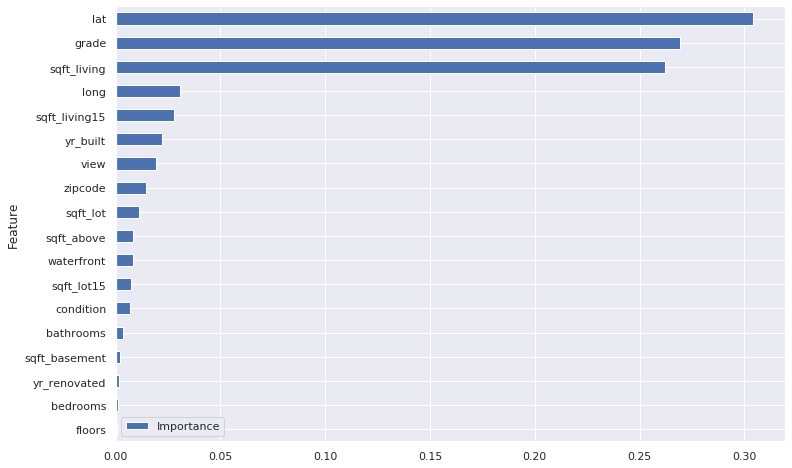

In [35]:
df_imp.sort_values('Importance').set_index('Feature').sort_values('Importance').plot.barh(figsize=(12,8))

# Hyper Parameter using hyperopt-sklearn for Gradient Boosting Regressor
References: 
- http://hyperopt.github.io/hyperopt-sklearn/
- https://github.com/hyperopt/hyperopt-sklearn

# Scale data for hyperparameter tuning
For sklearn we used pipeline with scaling, now for tuning hyperparameter using 
hyperopt, we need to scale them.

In [0]:
scaler = StandardScaler()
scaler.fit(Xtrain)

Xtrain_scaled = scaler.transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [0]:
# from hpsklearn import HyperoptEstimator, any_regressor
# from hyperopt import tpe
# estim = HyperoptEstimator(regressor=any_regressor('regressor'),  
#                             algo=tpe.suggest, trial_timeout=300)

# estim.fit(Xtrain_scaled, ytrain )

# print(estim.score(Xtest_scaled, ytest ) )
# print(estim.best_model() )

# Official example fails:
#
# ---> 95     return sklearn.linear_model.SGDRegressor(*args, **kwargs)
# TypeError: __init__() got an unexpected keyword argument 'n_iter'

In [0]:
# %%time
# from hpsklearn import gradient_boosting_regression
# from hpsklearn import HyperoptEstimator, any_regressor
# from hyperopt import tpe

# estim = HyperoptEstimator(regressor=gradient_boosting_regression('gbr'),  
#                             algo=tpe.suggest, trial_timeout=300)

# estim.fit(Xtrain_scaled, ytrain )

# print(estim.score(Xtest_scaled, ytest ) )
# print(estim.best_model() )

# scaled data gives fitting error
# ValueError: attempt to get argmin of an empty sequence

In [39]:
from hpsklearn import gradient_boosting_regression
from hpsklearn import HyperoptEstimator, any_regressor
from hyperopt import tpe

estim = HyperoptEstimator(regressor=gradient_boosting_regression('gbr'),  
                            algo=tpe.suggest, trial_timeout=300)

estim.fit(Xtrain, ytrain )

print(estim.score(Xtest, ytest ) )
print(estim.best_model() )

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
100%|██████████| 1/1 [00:00<00:00,  1.49it/s, best loss: 0.10502638439188017]
0.8297883148727474
{'learner': GradientBoostingRegressor(alpha=0.5, criterion='friedman_mse', init=None,
                          learning_rate=0.030436296469075703, loss='quantile',
                          max_depth=None, max_features=0.8340107985008011,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=3,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=245, n_iter_no_change=None,
                          presort='auto', random_state=3,
                          subsample=0.5131351702909814, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), 'preprocs': (

In [40]:
show_method_attributes(estim)

Object Type: <class 'hpsklearn.estimator.hyperopt_estimator'>



,0,1,2,3,4,5,6
0,algo,fit_increment,info,n_ex_pps,rstate,set_params,trials
1,best_model,fit_increment_dump_filename,loss_fn,predict,score,space,use_partial_fit
2,classification,fit_iter,max_evals,retrain_best_model_on_full_data,seed,trial_timeout,verbose
3,fit,get_params,,,,,


In [41]:
best_model = estim.best_model()['learner']
best_model

GradientBoostingRegressor(alpha=0.5, criterion='friedman_mse', init=None,
                          learning_rate=0.030436296469075703, loss='quantile',
                          max_depth=None, max_features=0.8340107985008011,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=3,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=245, n_iter_no_change=None,
                          presort='auto', random_state=3,
                          subsample=0.5131351702909814, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
%%time
best_model.fit(Xtrain, ytrain)

ypreds = best_model.predict(Xtest)

r2 = sklearn.metrics.r2_score(ytest, ypreds)
ar2 = adjustedR2(r2, Xtest.shape[0], Xtest.shape[1])

print ('Test MSE = ', mean_squared_error(ytest, ypreds))
print('r_squared   = ', r2)
print('adjustedr2 = ', ar2)

Test MSE =  0.02724777601038427
r_squared   =  0.9028081048942618
adjustedr2 =  0.9024243041470382
CPU times: user 1min 56s, sys: 40 ms, total: 1min 56s
Wall time: 1min 56s


In [0]:
# when I scale the data for hyperopt for lgb, it fails
# when I do not scale the data, it gives very low performance   adj-r2 = 0.8889
# but, I already have best adj-r2 = 0.90